In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import math
from PIL import ImageFilter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Carga de datos

### Dataset binario

In [2]:
# ImageDataGenerator

height, width = 224, 224
batch_size=64

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.) #estandarizar
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=64,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = 'train'
TESTING_DIR = 'test'

train_generator = generate_data(TRAINING_DIR)
print('\n\n',{'Normal_cases':len(np.where(train_generator.labels==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(train_generator.labels==1)[0]),
             'Covid_cases':len(np.where(train_generator.labels==2)[0])})

test_generator = generate_data(TESTING_DIR)
print('\n\n',{'Normal_cases':len(np.where(test_generator.labels==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(test_generator.labels==1)[0]),
             'Covid_cases':len(np.where(test_generator.labels==2)[0])})

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.


 {'Normal_cases': 70, 'Viral_Pneumonia_cases': 70, 'Covid_cases': 111}
Found 66 images belonging to 3 classes.


 {'Normal_cases': 20, 'Viral_Pneumonia_cases': 20, 'Covid_cases': 26}


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


In [3]:
train_generator.labels[train_generator.labels == 2] = 1
test_generator.labels[test_generator.labels == 2] = 1

In [4]:
train_generator.labels
print('\n\n',{'Normal_cases':len(np.where(train_generator.labels==0)[0]),
      'Sick_cases':len(np.where(train_generator.labels==1)[0])})



 {'Normal_cases': 70, 'Sick_cases': 181}


In [5]:
y_train = np.array([])
X_train = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    X_train.append(train_generator[i][0]) 
    y_train= np.concatenate((y_train,train_generator[i][-1])) 
    
X_train = np.concatenate((X_train),axis=0)

In [6]:
y_test = np.array([])
X_test = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    X_test.append(test_generator[i][0]) 
    y_test= np.concatenate((y_test,test_generator[i][-1])) 
    
X_test = np.concatenate((X_test),axis=0)

In [7]:
print(len(X_train))
print(len(X_test))
print(X_test[0].shape)
print(y_test)

251
66
(224, 224, 3)
[1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.]


## Visualización de las imágenes

Clase: 1.0


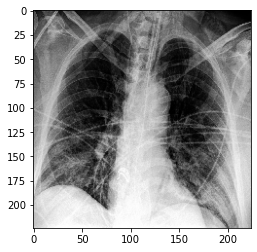

In [8]:
plt.imshow(X_train[0], 'gray')
print("Clase:", y_train[0])

Clase: 0.0


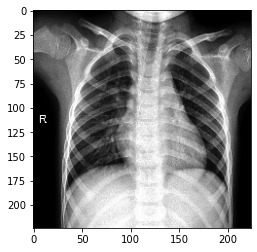

In [9]:
plt.imshow(X_test[2], 'gray')
print("Clase:", y_test[2])

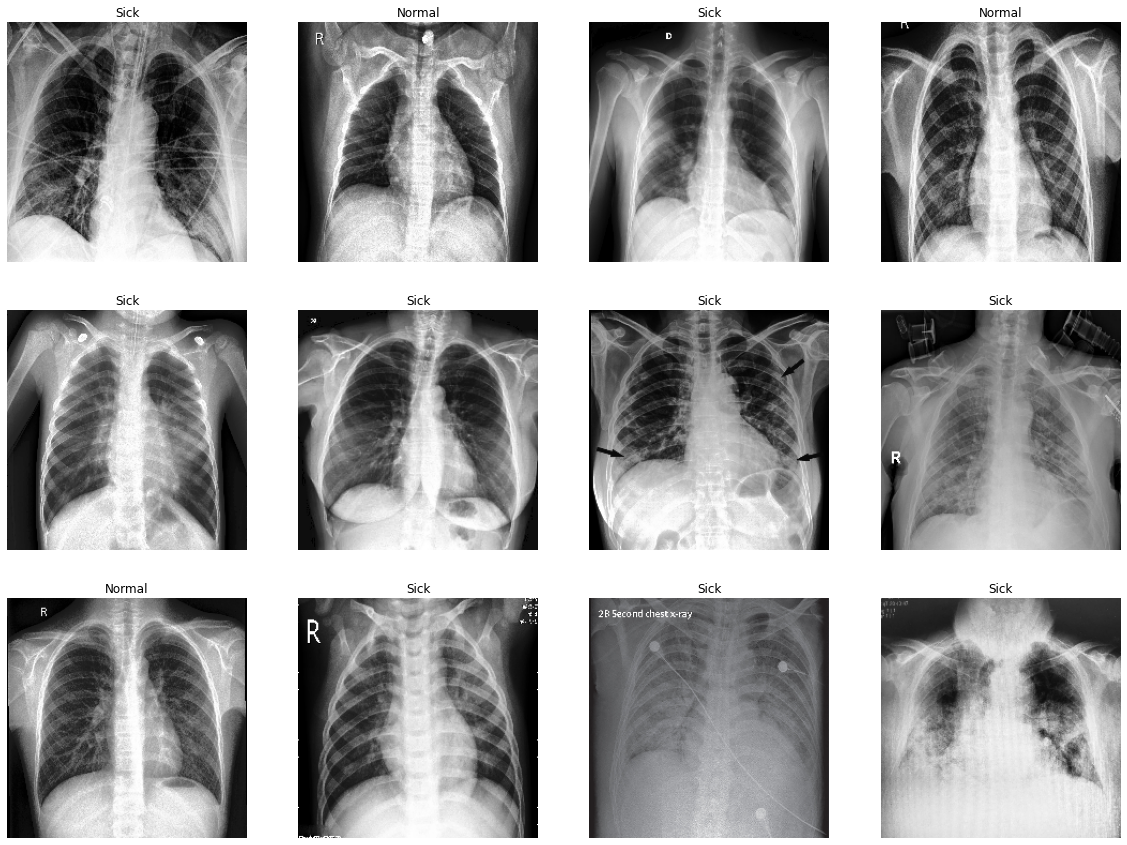

In [10]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Sick")
        plt.axis("off")

image_plot(train_generator,12)

## Codificación del target como variable nominal (ONE-HOT ENCODING)

In [11]:
y_train=y_train.astype('uint8')
y_test=y_test.astype('uint8')

In [12]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

### Modelo lineal (sin capas ocultas)

In [13]:
# La entrada a este tipo de modelo debe ser un array con tantas posiciones como píxeles
# De esta forma, cada imagen de 224x224x3 debe ser convertida en un vector con 150528 variables

trainvectors = X_train.reshape(251, 150528)
testvectors = X_test.reshape(66, 150528)
print(trainvectors.shape)
print(testvectors.shape)

(251, 150528)
(66, 150528)


In [14]:
# El modelo se define de forma secuencial: se definen las capas y se van añadiendo

from keras.models import Sequential
model_0 = Sequential()
# Se define la capa de salida a la cual le llegan todas las conexiones posibles desde la capa de entrada

from keras.layers.core import Dense
denselayer = Dense(2, input_shape=(150528,))
# Se añade dicha capa
model_0.add(denselayer)
# Se añade la función de activación
from keras.layers.core import Activation
model_0.add(Activation('sigmoid'))
# Se presenta la descripción del modelo
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 301058    
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 301,058
Trainable params: 301,058
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compilación de la red
# Se define la entropia cruzada como función de pérdida a minimizar (apropiada para clasificación multiclase)
# Se utilizar como método de optimización el Stochastic Gradient Descent
# Se incluye también el accuracy como una métrica a evaluar por el modelo
model_0.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [16]:
# Se entrena el modelo
import tensorflow as tf

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

history_0=model_0.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 1s 293ms/step - loss: 4.9240 - accuracy: 0.6400 - val_loss: 115.4708 - val_accuracy: 0.7647
Epoch 2/500
2/2 [==============================] - 0s 83ms/step - loss: 115.9513 - accuracy: 0.7100 - val_loss: 2.3042 - val_accuracy: 0.7255
Epoch 3/500
2/2 [==============================] - 0s 75ms/step - loss: 31.9878 - accuracy: 0.6750 - val_loss: 71.4924 - val_accuracy: 0.2353
Epoch 4/500
2/2 [==============================] - 0s 77ms/step - loss: 85.4986 - accuracy: 0.4600 - val_loss: 55.5498 - val_accuracy: 0.7647
Epoch 5/500
2/2 [==============================] - 0s 92ms/step - loss: 40.7467 - accuracy: 0.7400 - val_loss: 122.5180 - val_accuracy: 0.2353
Epoch 6/500
2/2 [==============================] - 0s 88ms/step - loss: 98.7421 - accuracy: 0.4800 - val_loss: 34.9012 - val_accuracy: 0.7647
Epoch 7/500
2/2 [==============================] - 0s 81ms/step - loss: 29.4885 - accuracy: 0.7200 - val_loss: 38.3447 - val_accuracy: 0.7647
Epoc

Clases predichas= [1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.77      0.50      0.61        20
           1       0.81      0.93      0.87        46

    accuracy                           0.80        66
   macro avg       0.79      0.72      0.74        66
weighted avg       0.80      0.80      0.79        66



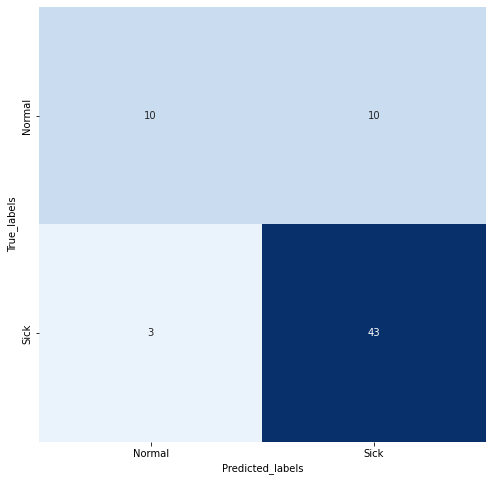

Test loss 6.1862945556640625
Test accuracy 0.8030303120613098


In [17]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_0.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_0.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)

from sklearn.metrics import classification_report
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_0.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

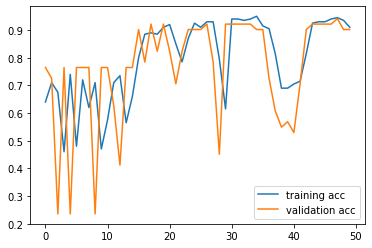

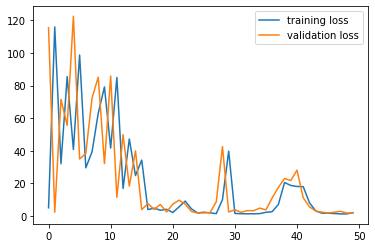

In [18]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_0)

### Red neuronal superficial (con una capa oculta)

In [19]:
model_1 = Sequential()
model_1.add(Dense(32, input_shape=(150528,)))
model_1.add(Activation('sigmoid'))
model_1.add(Dense(2))
model_1.add(Activation('sigmoid'))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                4816928   
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
Total params: 4,816,994
Trainable params: 4,816,994
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compilación de la red
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Se entrena el modelo
history_1=model_1.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 1s 315ms/step - loss: 1.1203 - accuracy: 0.4200 - val_loss: 1.0291 - val_accuracy: 0.7647
Epoch 2/500
2/2 [==============================] - 0s 102ms/step - loss: 1.2571 - accuracy: 0.7100 - val_loss: 0.9846 - val_accuracy: 0.7647
Epoch 3/500
2/2 [==============================] - 0s 100ms/step - loss: 1.1925 - accuracy: 0.7100 - val_loss: 0.9277 - val_accuracy: 0.7647
Epoch 4/500
2/2 [==============================] - 0s 118ms/step - loss: 1.1293 - accuracy: 0.7100 - val_loss: 0.8793 - val_accuracy: 0.7647
Epoch 5/500
2/2 [==============================] - 0s 104ms/step - loss: 1.0663 - accuracy: 0.7100 - val_loss: 0.8204 - val_accuracy: 0.7647
Epoch 6/500
2/2 [==============================] - 0s 91ms/step - loss: 0.9850 - accuracy: 0.7100 - val_loss: 0.7582 - val_accuracy: 0.7647
Epoch 7/500
2/2 [==============================] - 0s 89ms/step - loss: 0.9157 - accuracy: 0.7100 - val_loss: 0.7253 - val_accuracy: 0.7647
Epoch 8/500
2/2

Epoch 117/500
2/2 [==============================] - 0s 84ms/step - loss: 0.3039 - accuracy: 0.9250 - val_loss: 0.3098 - val_accuracy: 0.9412
Epoch 118/500
2/2 [==============================] - 0s 112ms/step - loss: 0.2953 - accuracy: 0.9400 - val_loss: 0.2930 - val_accuracy: 0.9412
Epoch 119/500
2/2 [==============================] - 0s 90ms/step - loss: 0.2877 - accuracy: 0.9450 - val_loss: 0.3022 - val_accuracy: 0.9412
Epoch 120/500
2/2 [==============================] - 0s 102ms/step - loss: 0.2843 - accuracy: 0.9500 - val_loss: 0.2713 - val_accuracy: 0.9216
Epoch 121/500
2/2 [==============================] - 0s 101ms/step - loss: 0.2735 - accuracy: 0.9450 - val_loss: 0.2679 - val_accuracy: 0.9216
Epoch 122/500
2/2 [==============================] - 0s 91ms/step - loss: 0.2788 - accuracy: 0.9500 - val_loss: 0.2882 - val_accuracy: 0.9020
Epoch 123/500
2/2 [==============================] - 0s 96ms/step - loss: 0.3127 - accuracy: 0.8950 - val_loss: 0.2788 - val_accuracy: 0.9020
Epo

2/2 [==============================] - 0s 107ms/step - loss: 0.1787 - accuracy: 0.9550 - val_loss: 0.1986 - val_accuracy: 0.9412
Epoch 232/500
2/2 [==============================] - 0s 97ms/step - loss: 0.1684 - accuracy: 0.9700 - val_loss: 0.1758 - val_accuracy: 0.9412
Epoch 233/500
2/2 [==============================] - 0s 90ms/step - loss: 0.1302 - accuracy: 0.9900 - val_loss: 0.1966 - val_accuracy: 0.9412
Epoch 234/500
2/2 [==============================] - 0s 85ms/step - loss: 0.1326 - accuracy: 0.9900 - val_loss: 0.1840 - val_accuracy: 0.9412
Epoch 235/500
2/2 [==============================] - 0s 117ms/step - loss: 0.1281 - accuracy: 0.9900 - val_loss: 0.1782 - val_accuracy: 0.9412
Epoch 236/500
2/2 [==============================] - 0s 96ms/step - loss: 0.1260 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 0.9412
Epoch 237/500
2/2 [==============================] - 0s 103ms/step - loss: 0.1251 - accuracy: 1.0000 - val_loss: 0.1707 - val_accuracy: 0.9608
Epoch 238/500
2/2

2/2 [==============================] - 0s 182ms/step - loss: 0.0695 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.9608
Epoch 346/500
2/2 [==============================] - 0s 105ms/step - loss: 0.0697 - accuracy: 1.0000 - val_loss: 0.1552 - val_accuracy: 0.9412
Epoch 347/500
2/2 [==============================] - 0s 88ms/step - loss: 0.0694 - accuracy: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9608
Epoch 348/500
2/2 [==============================] - 0s 123ms/step - loss: 0.0697 - accuracy: 1.0000 - val_loss: 0.1733 - val_accuracy: 0.9412
Epoch 349/500
2/2 [==============================] - 0s 112ms/step - loss: 0.0728 - accuracy: 1.0000 - val_loss: 0.1463 - val_accuracy: 0.9608
Epoch 350/500
2/2 [==============================] - 0s 90ms/step - loss: 0.0686 - accuracy: 1.0000 - val_loss: 0.1609 - val_accuracy: 0.9412
Epoch 351/500
2/2 [==============================] - 0s 100ms/step - loss: 0.0684 - accuracy: 1.0000 - val_loss: 0.1328 - val_accuracy: 0.9412
Epoch 352/500
2

Clases predichas= [1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.86      0.93      0.90        46

    accuracy                           0.85        66
   macro avg       0.84      0.79      0.81        66
weighted avg       0.85      0.85      0.84        66



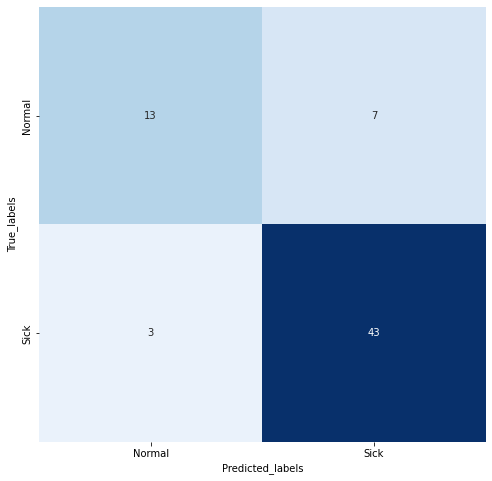

Test loss 0.3333781957626343
Test accuracy 0.8484848737716675


In [21]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_1.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_1.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_1.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

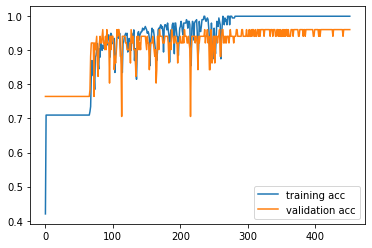

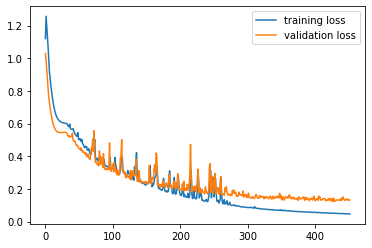

In [22]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_1)

### Red neuronal con dos capas

In [23]:
model_2 = Sequential()
model_2.add(Dense(64, input_shape=(150528,)))
model_2.add(Activation('sigmoid'))
model_2.add(Dense(32, input_shape=(150528,)))
model_2.add(Activation('sigmoid'))
model_2.add(Dense(2))
model_2.add(Activation('sigmoid'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                9633856   
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 activation_4 (Activation)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
 activation_5 (Activation)   (None, 2)                 0         
                                                                 
Total params: 9,636,002
Trainable params: 9,636,002
No

In [24]:
# Compilación de la red
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Se entrena el modelo

history_2=model_2.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list 
)

Epoch 1/500
2/2 [==============================] - 1s 606ms/step - loss: 0.9068 - accuracy: 0.4200 - val_loss: 0.5992 - val_accuracy: 0.7647
Epoch 2/500
2/2 [==============================] - 0s 200ms/step - loss: 0.6199 - accuracy: 0.7100 - val_loss: 0.5848 - val_accuracy: 0.7647
Epoch 3/500
2/2 [==============================] - 0s 138ms/step - loss: 0.6120 - accuracy: 0.7100 - val_loss: 0.5757 - val_accuracy: 0.7647
Epoch 4/500
2/2 [==============================] - 0s 161ms/step - loss: 0.6071 - accuracy: 0.7100 - val_loss: 0.5703 - val_accuracy: 0.7647
Epoch 5/500
2/2 [==============================] - 0s 158ms/step - loss: 0.6044 - accuracy: 0.7100 - val_loss: 0.5667 - val_accuracy: 0.7647
Epoch 6/500
2/2 [==============================] - 0s 197ms/step - loss: 0.6024 - accuracy: 0.7100 - val_loss: 0.5639 - val_accuracy: 0.7647
Epoch 7/500
2/2 [==============================] - 0s 185ms/step - loss: 0.6018 - accuracy: 0.7100 - val_loss: 0.5630 - val_accuracy: 0.7647
Epoch 8/500
2

Epoch 59/500
2/2 [==============================] - 0s 138ms/step - loss: 0.4325 - accuracy: 0.8000 - val_loss: 0.4094 - val_accuracy: 0.8431
Epoch 60/500
2/2 [==============================] - 0s 178ms/step - loss: 0.4287 - accuracy: 0.7950 - val_loss: 0.4060 - val_accuracy: 0.8431
Epoch 61/500
2/2 [==============================] - 0s 141ms/step - loss: 0.4262 - accuracy: 0.7950 - val_loss: 0.4031 - val_accuracy: 0.8431
Epoch 62/500
2/2 [==============================] - 0s 141ms/step - loss: 0.4235 - accuracy: 0.7950 - val_loss: 0.4031 - val_accuracy: 0.8431
Epoch 63/500
2/2 [==============================] - 0s 146ms/step - loss: 0.4210 - accuracy: 0.8000 - val_loss: 0.3988 - val_accuracy: 0.8431
Epoch 64/500
2/2 [==============================] - 0s 144ms/step - loss: 0.4187 - accuracy: 0.8050 - val_loss: 0.3947 - val_accuracy: 0.8431
Epoch 65/500
2/2 [==============================] - 0s 145ms/step - loss: 0.4168 - accuracy: 0.7950 - val_loss: 0.4051 - val_accuracy: 0.8627
Epoch 

2/2 [==============================] - 0s 129ms/step - loss: 0.2090 - accuracy: 0.9550 - val_loss: 0.2393 - val_accuracy: 0.9412
Epoch 174/500
2/2 [==============================] - 0s 134ms/step - loss: 0.2088 - accuracy: 0.9650 - val_loss: 0.2270 - val_accuracy: 0.9216
Epoch 175/500
2/2 [==============================] - 0s 174ms/step - loss: 0.2048 - accuracy: 0.9650 - val_loss: 0.2193 - val_accuracy: 0.9216
Epoch 176/500
2/2 [==============================] - 0s 145ms/step - loss: 0.2040 - accuracy: 0.9600 - val_loss: 0.2283 - val_accuracy: 0.9412
Epoch 177/500
2/2 [==============================] - 0s 165ms/step - loss: 0.2024 - accuracy: 0.9600 - val_loss: 0.2179 - val_accuracy: 0.9216
Epoch 178/500
2/2 [==============================] - 0s 145ms/step - loss: 0.2018 - accuracy: 0.9600 - val_loss: 0.2272 - val_accuracy: 0.9412
Epoch 179/500
2/2 [==============================] - 0s 159ms/step - loss: 0.2006 - accuracy: 0.9600 - val_loss: 0.2157 - val_accuracy: 0.9216
Epoch 180/500

2/2 [==============================] - 0s 141ms/step - loss: 0.1062 - accuracy: 0.9950 - val_loss: 0.1586 - val_accuracy: 0.9412
Epoch 288/500
2/2 [==============================] - 0s 200ms/step - loss: 0.1088 - accuracy: 0.9850 - val_loss: 0.1544 - val_accuracy: 0.9608
Epoch 289/500
2/2 [==============================] - 0s 156ms/step - loss: 0.1090 - accuracy: 0.9850 - val_loss: 0.1562 - val_accuracy: 0.9412
Epoch 290/500
2/2 [==============================] - 0s 145ms/step - loss: 0.1043 - accuracy: 0.9850 - val_loss: 0.1648 - val_accuracy: 0.9412
Epoch 291/500
2/2 [==============================] - 0s 158ms/step - loss: 0.1035 - accuracy: 0.9900 - val_loss: 0.1548 - val_accuracy: 0.9608
Epoch 292/500
2/2 [==============================] - 0s 158ms/step - loss: 0.1100 - accuracy: 0.9800 - val_loss: 0.1533 - val_accuracy: 0.9608
Epoch 293/500
2/2 [==============================] - 0s 146ms/step - loss: 0.1084 - accuracy: 0.9750 - val_loss: 0.1559 - val_accuracy: 0.9412
Epoch 294/500

2/2 [==============================] - 0s 212ms/step - loss: 0.0588 - accuracy: 1.0000 - val_loss: 0.1362 - val_accuracy: 0.9412
Epoch 402/500
2/2 [==============================] - 0s 212ms/step - loss: 0.0599 - accuracy: 1.0000 - val_loss: 0.1567 - val_accuracy: 0.9412
Epoch 403/500
2/2 [==============================] - 0s 264ms/step - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.1377 - val_accuracy: 0.9412
Epoch 404/500
2/2 [==============================] - 1s 359ms/step - loss: 0.0580 - accuracy: 1.0000 - val_loss: 0.1373 - val_accuracy: 0.9412
Epoch 405/500
2/2 [==============================] - 1s 351ms/step - loss: 0.0589 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.9412
Epoch 406/500
2/2 [==============================] - 0s 208ms/step - loss: 0.0592 - accuracy: 1.0000 - val_loss: 0.1368 - val_accuracy: 0.9412
Epoch 407/500
2/2 [==============================] - 0s 216ms/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 0.1271 - val_accuracy: 0.9608
Epoch 408/500

Clases predichas= [1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.86      0.93      0.90        46

    accuracy                           0.85        66
   macro avg       0.84      0.79      0.81        66
weighted avg       0.85      0.85      0.84        66



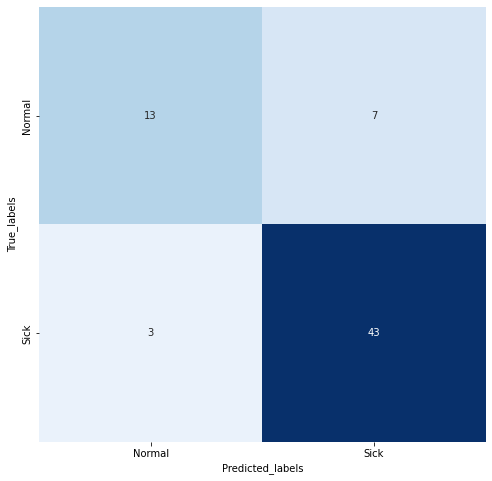

Test loss 0.311810165643692
Test accuracy 0.8484848737716675


In [25]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_2.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_2.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_2.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

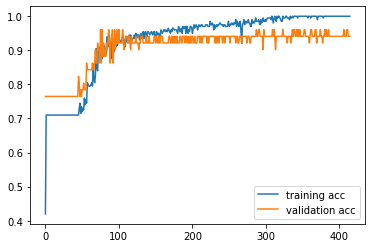

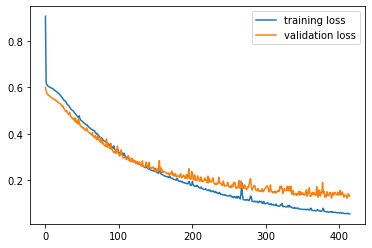

In [26]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_2)

### Red neuronal con dos capas, activación relu y solver adam

In [27]:
model_2ra = Sequential()
model_2ra.add(Dense(64, input_shape=(150528,)))
model_2ra.add(Activation('relu'))
model_2ra.add(Dense(32, input_shape=(150528,)))
model_2ra.add(Activation('relu'))
model_2ra.add(Dense(2))
model_2ra.add(Activation('sigmoid'))
model_2ra.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                9633856   
                                                                 
 activation_6 (Activation)   (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
 activation_8 (Activation)   (None, 2)                 0         
                                                                 
Total params: 9,636,002
Trainable params: 9,636,002
No

In [28]:
# Compilación de la red
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_2ra.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_2ra=model_2ra.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list 
)

Epoch 1/500
2/2 [==============================] - 2s 787ms/step - loss: 6.1625 - accuracy: 0.4200 - val_loss: 13.4296 - val_accuracy: 0.2353
Epoch 2/500
2/2 [==============================] - 0s 197ms/step - loss: 14.1462 - accuracy: 0.3900 - val_loss: 13.6738 - val_accuracy: 0.7647
Epoch 3/500
2/2 [==============================] - 0s 192ms/step - loss: 15.8512 - accuracy: 0.7100 - val_loss: 5.4015 - val_accuracy: 0.7647
Epoch 4/500
2/2 [==============================] - 0s 162ms/step - loss: 5.2171 - accuracy: 0.6700 - val_loss: 9.1106 - val_accuracy: 0.3333
Epoch 5/500
2/2 [==============================] - 0s 191ms/step - loss: 4.6379 - accuracy: 0.6150 - val_loss: 2.7553 - val_accuracy: 0.7647
Epoch 6/500
2/2 [==============================] - 0s 218ms/step - loss: 3.5242 - accuracy: 0.7100 - val_loss: 0.3498 - val_accuracy: 0.9216
Epoch 7/500
2/2 [==============================] - 0s 174ms/step - loss: 0.6525 - accuracy: 0.8900 - val_loss: 3.2334 - val_accuracy: 0.5686
Epoch 8/5

Epoch 59/500
2/2 [==============================] - 0s 162ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1215 - val_accuracy: 0.9412
Epoch 60/500
2/2 [==============================] - 0s 179ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1125 - val_accuracy: 0.9412
Epoch 61/500
2/2 [==============================] - 0s 184ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1173 - val_accuracy: 0.9412
Epoch 62/500
2/2 [==============================] - 0s 163ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1297 - val_accuracy: 0.9608
Epoch 63/500
2/2 [==============================] - 0s 182ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 0.9608
Epoch 64/500
2/2 [==============================] - 0s 167ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1505 - val_accuracy: 0.9608
Epoch 65/500
2/2 [==============================] - 0s 172ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1511 - val_accuracy: 0.9608
Epoch 

Clases predichas= [1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.88      0.93      0.91        46

    accuracy                           0.86        66
   macro avg       0.85      0.82      0.83        66
weighted avg       0.86      0.86      0.86        66



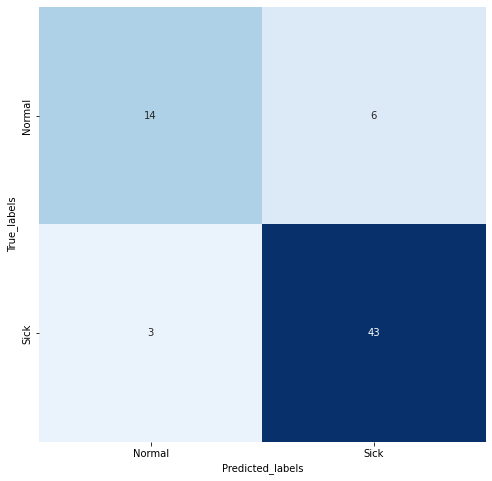

Test loss 0.6680361032485962
Test accuracy 0.8636363744735718


In [29]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_2ra.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_2ra.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_2ra.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

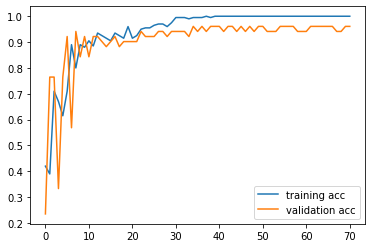

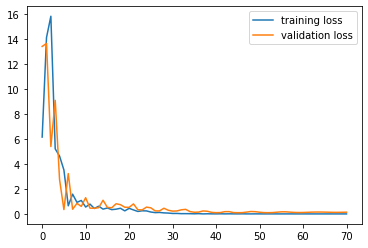

In [30]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_2ra)

### Red neuronal con dos capas y regularizador DROPOUT

In [31]:
# Se busca evitar desvanecimiento del gradiente (tenemos ya más de una capa)
# Además, el término regularizador suele ayudar a que el modelo sobreajuste menos
# Mayor porcentaje de dropout en capas cercanas a la salida

from keras.layers.core import Dropout
model_2rad = Sequential()
model_2rad.add(Dense(64, input_shape=(150528,)))
model_2rad.add(Activation('relu'))
model_2rad.add(Dropout(0.1))
model_2rad.add(Dense(32, input_shape=(150528,)))
model_2rad.add(Activation('relu'))
model_2rad.add(Dropout(0.2))
model_2rad.add(Dense(2))
model_2rad.add(Activation('sigmoid'))
model_2rad.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                9633856   
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 activation_10 (Activation)  (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                

In [32]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_2rad.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_2rad=model_2rad.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 2s 512ms/step - loss: 8.7772 - accuracy: 0.6350 - val_loss: 122.2456 - val_accuracy: 0.2353
Epoch 2/500
2/2 [==============================] - 0s 189ms/step - loss: 76.1753 - accuracy: 0.4000 - val_loss: 19.6448 - val_accuracy: 0.7647
Epoch 3/500
2/2 [==============================] - 0s 187ms/step - loss: 27.9215 - accuracy: 0.6750 - val_loss: 14.1320 - val_accuracy: 0.7647
Epoch 4/500
2/2 [==============================] - 0s 225ms/step - loss: 20.9714 - accuracy: 0.6800 - val_loss: 2.5447 - val_accuracy: 0.7059
Epoch 5/500
2/2 [==============================] - 0s 253ms/step - loss: 18.3596 - accuracy: 0.5300 - val_loss: 2.1201 - val_accuracy: 0.4314
Epoch 6/500
2/2 [==============================] - 0s 172ms/step - loss: 16.2044 - accuracy: 0.5200 - val_loss: 5.9247 - val_accuracy: 0.7647
Epoch 7/500
2/2 [==============================] - 0s 175ms/step - loss: 14.1370 - accuracy: 0.6250 - val_loss: 5.5505 - val_accuracy: 0.7647
Epo

Epoch 59/500
2/2 [==============================] - 0s 178ms/step - loss: 0.4374 - accuracy: 0.9000 - val_loss: 0.2877 - val_accuracy: 0.9412
Epoch 60/500
2/2 [==============================] - 0s 139ms/step - loss: 0.3894 - accuracy: 0.9100 - val_loss: 0.2016 - val_accuracy: 0.9608
Epoch 61/500
2/2 [==============================] - 0s 163ms/step - loss: 0.4762 - accuracy: 0.8950 - val_loss: 0.2321 - val_accuracy: 0.8824
Epoch 62/500
2/2 [==============================] - 0s 157ms/step - loss: 0.3316 - accuracy: 0.8850 - val_loss: 0.2748 - val_accuracy: 0.8627
Epoch 63/500
2/2 [==============================] - 0s 137ms/step - loss: 0.3139 - accuracy: 0.8550 - val_loss: 0.2317 - val_accuracy: 0.8824
Epoch 64/500
2/2 [==============================] - 0s 159ms/step - loss: 0.3210 - accuracy: 0.8900 - val_loss: 0.2463 - val_accuracy: 0.9020
Epoch 65/500
2/2 [==============================] - 0s 138ms/step - loss: 0.2522 - accuracy: 0.9100 - val_loss: 0.2105 - val_accuracy: 0.9608
Epoch 

Clases predichas= [1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.85      0.96      0.90        46

    accuracy                           0.85        66
   macro avg       0.85      0.78      0.80        66
weighted avg       0.85      0.85      0.84        66



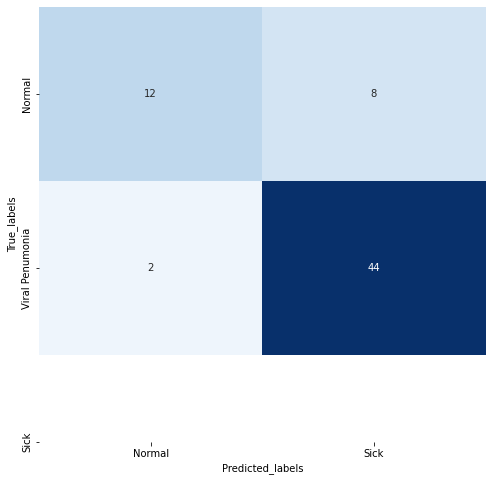

Test loss 0.6112547516822815
Test accuracy 0.8484848737716675


In [33]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_2rad.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_2rad.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Viral Penumonia','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_2rad.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

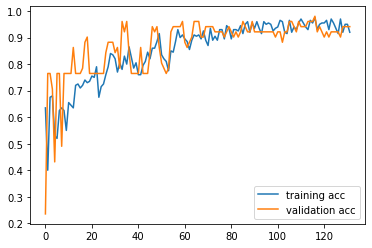

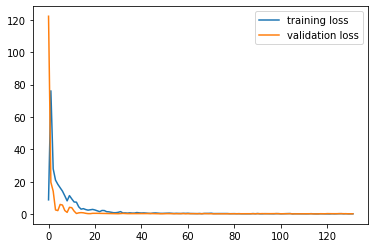

In [34]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_2rad)

### Red neuronal con tres capas 

In [35]:
# Se busca evitar desvanecimiento del gradiente (tenemos ya más de una capa)
# Además, el término regularizador suele ayudar a que el modelo sobreajuste menos
# Mayor porcentaje de dropout en capas cercanas a la salida

from keras.layers.core import Dropout
model_3rad = Sequential()
model_3rad.add(Dense(64, input_shape=(150528,)))
model_3rad.add(Activation('relu'))
#model_3rad.add(Dropout(0.05))
model_3rad.add(Dense(32, input_shape=(150528,)))
model_3rad.add(Activation('relu'))
#model_3rad.add(Dropout(0.1))
model_3rad.add(Dense(16, input_shape=(150528,)))
model_3rad.add(Activation('relu'))
#model_3rad.add(Dropout(0.2))
model_3rad.add(Dense(2))
model_3rad.add(Activation('sigmoid'))
model_3rad.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                9633856   
                                                                 
 activation_12 (Activation)  (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 activation_13 (Activation)  (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 activation_14 (Activation)  (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                

In [36]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_3rad.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_3rad=model_3rad.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 1s 433ms/step - loss: 4.6102 - accuracy: 0.5600 - val_loss: 59.6336 - val_accuracy: 0.2353
Epoch 2/500
2/2 [==============================] - 0s 242ms/step - loss: 37.9807 - accuracy: 0.4400 - val_loss: 5.2848 - val_accuracy: 0.7647
Epoch 3/500
2/2 [==============================] - 0s 180ms/step - loss: 5.4913 - accuracy: 0.6350 - val_loss: 1.1463 - val_accuracy: 0.7647
Epoch 4/500
2/2 [==============================] - 0s 186ms/step - loss: 1.2140 - accuracy: 0.7850 - val_loss: 0.9409 - val_accuracy: 0.8039
Epoch 5/500
2/2 [==============================] - 0s 164ms/step - loss: 0.5809 - accuracy: 0.8450 - val_loss: 0.4067 - val_accuracy: 0.8824
Epoch 6/500
2/2 [==============================] - 0s 177ms/step - loss: 0.5666 - accuracy: 0.8950 - val_loss: 0.6154 - val_accuracy: 0.8627
Epoch 7/500
2/2 [==============================] - 0s 175ms/step - loss: 0.5687 - accuracy: 0.8650 - val_loss: 0.2327 - val_accuracy: 0.9412
Epoch 8/500

Clases predichas= [1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.88      0.93      0.91        46

    accuracy                           0.86        66
   macro avg       0.85      0.82      0.83        66
weighted avg       0.86      0.86      0.86        66



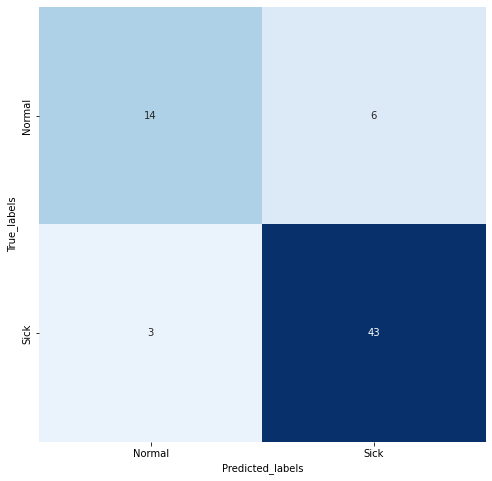

Test loss 0.47512105107307434
Test accuracy 0.8636363744735718


In [37]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_3rad.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_3rad.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_3rad.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

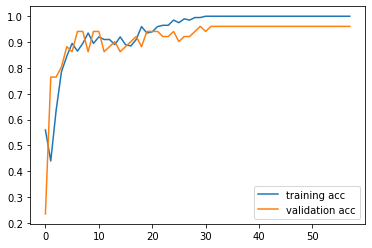

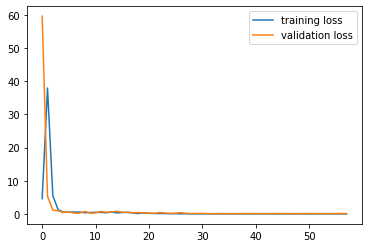

In [38]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_3rad)

### Red neuronal convolucional

In [39]:
# En este caso, ya no vale la estructura vectorial, 
# sino que lo datos deben ser guardados como tensores 
# haciendo referencia a la imagen tal y como fue leída originalmente (nº filas x nº columnas) 
# y al número de canales de color (en este caso 1)

traintensor = X_train.reshape(251, 224, 224, 3)
testtensor = X_test.reshape(66, 224, 224, 3)

In [50]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D

numero_filas = 224
numero_columnas = 224
numero_canales = 3
kernel_size = 3 # Tamaño del kernel (de cada máscara / matriz de convolución)
pool_size = 2 # Tamaño del pooling

model_c1 = Sequential()

model_c1.add(Convolution2D(64, # Número de máscaras de convolución
                        kernel_size, kernel_size, # Size of convolution kernels
                        #border_mode='valid', # Strategy to deal with borders
                        input_shape=(numero_filas, numero_columnas, numero_canales))) 
model_c1.add(Activation('relu'))
model_c1.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#model_c1.add(Dropout(0.1))

# Es necesario destransfomar el tensor a un vector porque el output de la red  debería ser un vector 
# con 3 valores (que representarían las "probabilidades" de pertenencia a cada clase)
# Para ello, se utiliza una capa de tipo Flatten, que vuelve a dar estructura de vector
# y sobre la cual, se podría volver a añadir el clasificador anterior (un perceptrón multicapa)
        
from keras.layers.core import Flatten
model_c1.add(Flatten())
model_c1.add(Dense(64))
model_c1.add(Activation('relu'))
#model_c1.add(Dropout(0.1))
model_c1.add(Dense(32))
model_c1.add(Activation('relu'))
#model_c1.add(Dropout(0.2))
model_c1.add(Dense(2))
model_c1.add(Activation('sigmoid'))
model_c1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 74, 74, 64)        1792      
                                                                 
 activation_24 (Activation)  (None, 74, 74, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 87616)             0         
                                                                 
 dense_22 (Dense)            (None, 64)                5607488   
                                                                 
 activation_25 (Activation)  (None, 64)                0         
                                                      

There is an issue, though: at some point we need to transform the tensor data into a vector, as the output of the network should be a vector of 3 values, representing class probabilities. We can do this by using a **Flatten** layer. Then we can add a standard Dense layer to produce the outputs:

In [51]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_c1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo
# NOTA: Cambiar trainvector por traintensor

history_c1=model_c1.fit(
    traintensor, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos 
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 3s 748ms/step - loss: 1.5157 - accuracy: 0.4850 - val_loss: 1.2591 - val_accuracy: 0.7647
Epoch 2/500
2/2 [==============================] - 1s 386ms/step - loss: 1.1870 - accuracy: 0.6800 - val_loss: 0.5100 - val_accuracy: 0.7647
Epoch 3/500
2/2 [==============================] - 1s 396ms/step - loss: 0.5568 - accuracy: 0.7100 - val_loss: 0.4572 - val_accuracy: 0.7647
Epoch 4/500
2/2 [==============================] - 1s 403ms/step - loss: 0.4934 - accuracy: 0.7450 - val_loss: 0.6025 - val_accuracy: 0.6471
Epoch 5/500
2/2 [==============================] - 1s 373ms/step - loss: 0.5447 - accuracy: 0.6600 - val_loss: 0.4044 - val_accuracy: 0.7647
Epoch 6/500
2/2 [==============================] - 1s 391ms/step - loss: 0.4135 - accuracy: 0.7150 - val_loss: 0.3484 - val_accuracy: 0.9020
Epoch 7/500
2/2 [==============================] - 1s 466ms/step - loss: 0.3109 - accuracy: 0.9300 - val_loss: 0.3113 - val_accuracy: 0.9216
Epoch 8/500
2

Clases predichas= [1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1]
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.92      0.98      0.95        46

    accuracy                           0.92        66
   macro avg       0.93      0.89      0.91        66
weighted avg       0.93      0.92      0.92        66



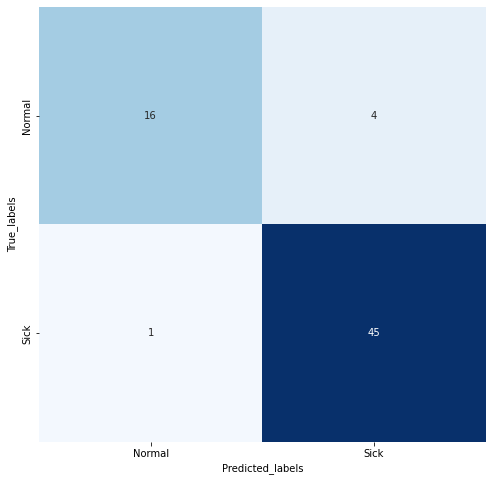

Test loss 0.15562479197978973
Test accuracy 0.9242424368858337


In [52]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_c1.predict(testtensor, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_c1.predict(testtensor, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
from sklearn.metrics import classification_report
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_c1.evaluate(testtensor, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

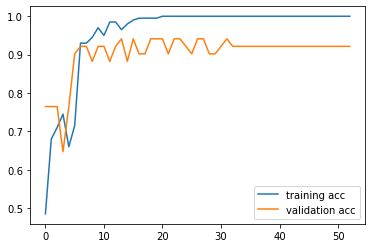

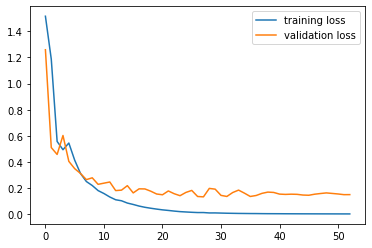

In [53]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_c1)

### Red neuronal convolucional más neuronas

In [65]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D

numero_filas = 224
numero_columnas = 224
numero_canales = 3
kernel_size = 3 # Tamaño del kernel (de cada máscara / matriz de convolución)
pool_size = 2 # Tamaño del pooling

model_c2 = Sequential()

model_c2.add(Convolution2D(256, # Número de máscaras de convolución
                        kernel_size, kernel_size, # Size of convolution kernels
                        #border_mode='valid', # Strategy to deal with borders
                        input_shape=(numero_filas, numero_columnas, numero_canales))) 
model_c2.add(Activation('relu'))
model_c2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#model_c2.add(Dropout(0.2))

# Es necesario destransfomar el tensor a un vector porque el output de la red  debería ser un vector 
# con 3 valores (que representarían las "probabilidades" de pertenencia a cada clase)
# Para ello, se utiliza una capa de tipo Flatten, que vuelve a dar estructura de vector
# y sobre la cual, se podría volver a añadir el clasificador anterior (un perceptrón multicapa)
        
from keras.layers.core import Flatten
model_c2.add(Flatten())
model_c2.add(Dense(256))
model_c2.add(Activation('relu'))
#model_c2.add(Dropout(0.2))
model_c2.add(Dense(128)) 
model_c2.add(Activation('relu'))
#model_c2.add(Dropout(0.4))
model_c2.add(Dense(2))
model_c2.add(Activation('sigmoid'))
model_c2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 74, 74, 256)       7168      
                                                                 
 activation_36 (Activation)  (None, 74, 74, 256)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 256)      0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 350464)            0         
                                                                 
 dense_31 (Dense)            (None, 256)               89719040  
                                                                 
 activation_37 (Activation)  (None, 256)               0         
                                                     

In [66]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=15)

callbacks_list = [early]

model_c2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_c2=model_c2.fit(
    traintensor, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos 
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list)

Epoch 1/500
2/2 [==============================] - 17s 4s/step - loss: 6.8860 - accuracy: 0.6650 - val_loss: 4.2219 - val_accuracy: 0.7647
Epoch 2/500
2/2 [==============================] - 10s 4s/step - loss: 5.1567 - accuracy: 0.5600 - val_loss: 0.4702 - val_accuracy: 0.8235
Epoch 3/500
2/2 [==============================] - 6s 2s/step - loss: 0.8534 - accuracy: 0.8600 - val_loss: 1.1806 - val_accuracy: 0.7647
Epoch 4/500
2/2 [==============================] - 5s 2s/step - loss: 1.1967 - accuracy: 0.7100 - val_loss: 0.4078 - val_accuracy: 0.7647
Epoch 5/500
2/2 [==============================] - 5s 2s/step - loss: 0.5421 - accuracy: 0.6150 - val_loss: 0.6082 - val_accuracy: 0.6863
Epoch 6/500
2/2 [==============================] - 4s 2s/step - loss: 0.4676 - accuracy: 0.8300 - val_loss: 0.4089 - val_accuracy: 0.7647
Epoch 7/500
2/2 [==============================] - 4s 2s/step - loss: 0.3798 - accuracy: 0.7500 - val_loss: 0.3885 - val_accuracy: 0.8627
Epoch 8/500
2/2 [===============

Clases predichas= [1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.94      0.98      0.96        46

    accuracy                           0.94        66
   macro avg       0.94      0.91      0.93        66
weighted avg       0.94      0.94      0.94        66



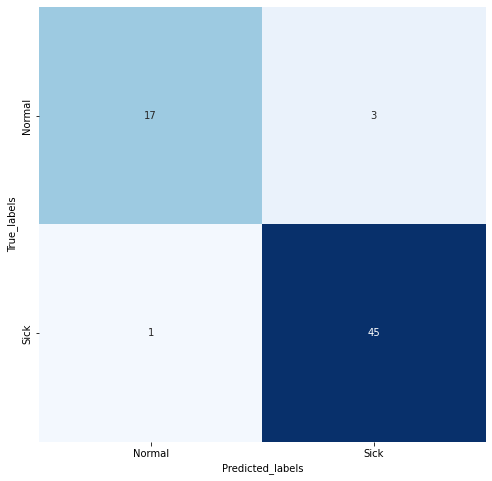

Test loss 0.18091118335723877
Test accuracy 0.939393937587738


In [67]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_c2.predict(testtensor, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_c2.predict(testtensor, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_c2.evaluate(testtensor, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

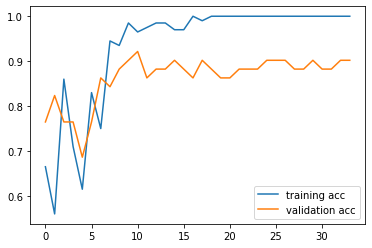

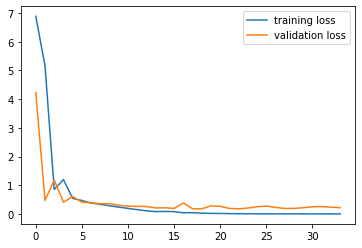

In [68]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history_c2)

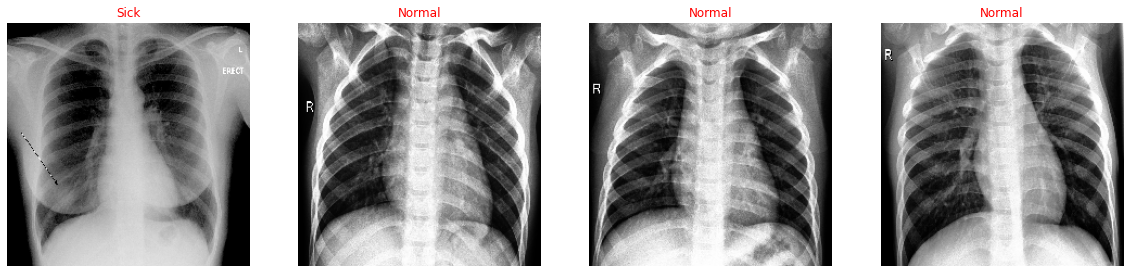

In [69]:
#Extract wrong classification index
wrong_pred = np.where(y_test!= prediccion_clases)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(X_test[n])
    plt.title("Normal" if y_test[n] == 0 else "Sick" if y_test[n] == 1 else "Covid",color='r')
    plt.axis("off")

In [70]:
import keras
model_c2.save('path_to_my_model_binary.h5')
del model_c2
model_c2_saved = keras.models.load_model('path_to_my_model_binary.h5')

Clases predichas= [1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.94      0.98      0.96        46

    accuracy                           0.94        66
   macro avg       0.94      0.91      0.93        66
weighted avg       0.94      0.94      0.94        66



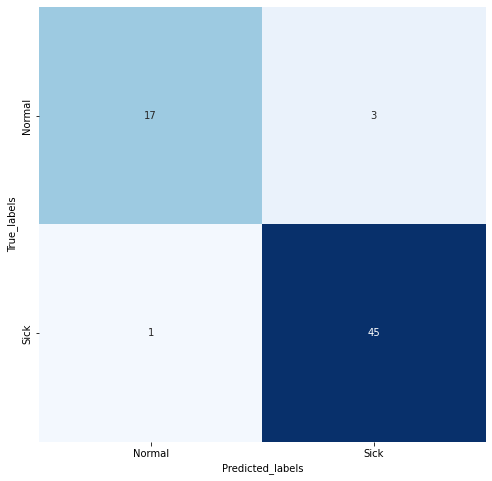

Test loss 0.18091118335723877
Test accuracy 0.939393937587738


In [71]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_c2_saved.predict(testtensor, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_c2_saved.predict(testtensor, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Sick'],yticklabels=['Normal','Sick'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_c2_saved.evaluate(testtensor, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])